In [1]:
import numpy as np
import matplotlib.pyplot as plt

def softmax(X):                                                                 ###converts log probabilities to probabilities
  norm = np.sum(np.exp(X)+10**-5)
  Y = (np.exp(X)+10**-5)/norm
  return Y

def softmax_dim2(X):                                                            ###converts matrix of log probabilities to matrix of probabilities
  norm = np.sum(np.exp(X)+10**-5,axis=0)
  Y = (np.exp(X)+10**-5)/norm
  return Y

def normalise(X):                                                               ###normalises a matrix of probabilities
  X= X/np.sum(X,0)
  return X

def predict(X,B):
  return np.inner(B,X)                                                          # Generate next state estimate, prediction step of filter

# Correction step given a likelihood matrix and observation vector.
# Formally a backwards BP message over a discrete transition node.
# Observations are np arrays that sum to 1, ie Categorical distributions
def obs_correct(X,A,obs):
  return softmax(np.log(X)+np.log(np.transpose(A) @ obs))
  
# Check if we pass a confidence threshold for network activity
def fire(X,threshold):
    return X > threshold

In [82]:
# parameter functions

# Likelihood matrix defined for each presynaptic neuron with some initial confidence (Palacios et al. use 0.5) on observations. 

def get_likelihood(number_of_presynaptic_neurons, initial_confidence):
  ''' 
  Generates the likelihood matrices given the number of inputs and initial observation precision. 
  '''
  p = initial_confidence
  assert 0 <= p <= 1, "Confidence must be in range [0,1]"
  A = np.zeros((number_of_presynaptic_neurons,2,2))
  for i in range(number_of_presynaptic_neurons):
    A[i,:,0] = [1-p , p]
    A[i,:,1] = [p , 1-p]
  return A

# Inspired by Palacios et al. 2019
# Tranisition matrix depends on the neuron's 'memory' of it's own recent activity. 
# If the neuron has fired in the 'interspike interval' then it expects to continue firing. 
# This slightly unusual formulation approximates a deep temporal model. 

def get_transition_matrix(tau, t_min, t_max, Xbar):
  recent_fire = 0
  B = np.zeros((2,2))

  for x in Xbar[0,max(0,tau-t_max):max(0,tau-t_min)]:
    if x > 0.5: 
      recent_fire = 1
      break
  if recent_fire == 0:
    B[:,0]=[0.2,.8]
    B[:,1]=[0.2,.8]
  else:
    B[:,0]=[.8,.2]
    B[:,1]=[.8,.2]  
  return B


In [63]:
# parameters for testing
number_of_presynaptic_neurons = 1

#timesteps
T = 20

# initial time step
tau = 0

# interspike interval
t_min = 1
t_max = 3

# initialise internal neuron state priors and posteriors (network firing vs network silent)
X = np.zeros((2,T))
Xbar = np.zeros((2,T))

# state prior D
X[:,0] = [0.5,0.5]

# observations (silent 0 vs fire 1)
O = np.zeros(T)

# initial input

O = np.ones(T)
O[6] = 0
O[7] = 0
O[8] = 0
O[9] = 0
O[10] = 0
O[11] = 0

# action potential generated by the neuron (starts silent)
O_out = np.zeros(T-1)


In [ ]:
# run experiment for one neuron

A = get_likelihood(1, 0.95)

for t in range(T):
    print(t)
    # get internal model based on historic activity
    B_t = get_transition_matrix(t, t_min, t_max, Xbar)

    ## calculate perceptual state posterior given observation
    Xbar[:,t] = softmax(np.log(X[:,t])+np.log(A[0,int(O[t]),:]))

    if t < (T-1):
        # generate action - the probability of firing depends on the neuron's beleif that it is participating in a firing vs silent network
        O_out[t] = np.random.choice([1,0], p=Xbar[:,t])

        #evolve expected state
        X[:,t+1] = np.inner(B_t, Xbar[:,t])

In [100]:
# define connections between neurons (1 if connected)
connectivity_matrix = np.array([[0,1],[0,0]])
unique, counts = np.unique(connectivity_matrix[0], return_counts=True)
print(counts)

output_matrix = np.zeros((len(connectivity_matrix),T))
print(output_matrix)

[1 1]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [94]:
class Neuron:
    def __init__(self, index, connectivity_matrix, output_matrix, T):
        self.index = index
        self.init_precision = 0.9
        u, counts = np.unique(connectivity_matrix[self.index], return_counts=True)
        assert len(counts) == 2, "Neuron has no connections. Check the connectivity matrix."
        self.number_of_presynaptic_neurons = counts[1]
        self.A = get_likelihood(self.number_of_presynaptic_neurons, self.init_precision)
        self.X = np.zeros((2,T))
        self.X[:,0] = [0.5,0.5]
        self.Xbar = np.zeros((2,T))
        self.O = np.zeros(T)
        self.O_out = output_matrix[0]

        # define 'refractory period'
        self.t_min = 1
        self.t_max = 3

    def get_transition_matrix(self, t):
        recent_fire = 0
        B = np.zeros((2,2))
        for x in self.Xbar[0,max(0,t-self.t_max):max(0,t-self.t_min)]:
            if x > 0.5: 
                recent_fire = 1
                break
        if recent_fire == 0:
            B[:,0]=[0.2,.8]
            B[:,1]=[0.2,.8]
        else:
            B[:,0]=[.8,.2]
            B[:,1]=[.8,.2]  
        return B

    def perceive_network(self, t):
        self.O[t] = output_matrix[1,t]
        self.Xbar[:,t] = softmax(np.log(self.X[:,t])+np.log(self.A[0,int(self.O[t]),:]))
        return self.Xbar[:,t]

    def broadcast_beliefs(self, t):
        self.O_out[t] = np.random.choice([1,0], p=self.Xbar[:,t])
        return self.O_out[t]

    def predict(self, t):
        B_t = get_transition_matrix(t)
        self.X[:,t+1] = np.inner(B_t, self.Xbar[:,t])

In [97]:
neuron_0 = Neuron(0, connectivity_matrix, 0.9, T)
print(neuron_0.number_of_presynaptic_neurons)
neuron_0.A

1


array([[[0.1, 0.9],
        [0.9, 0.1]]])

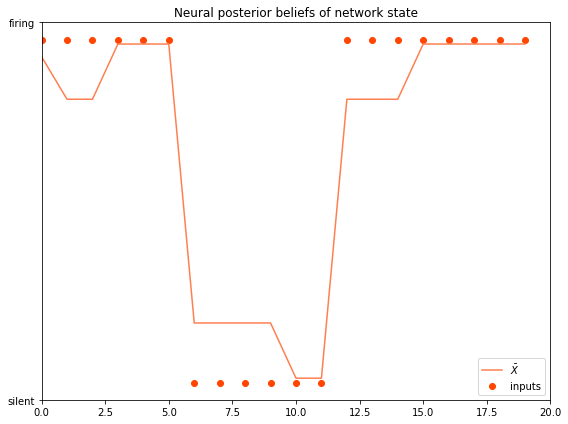

In [41]:
plt.figure(figsize=(8,6))

#plt.plot(1.5+np.arange(0,T-1),Pi2[0,:-1],label='stay (prior)',linestyle='--')
#plt.plot(np.arange(1,T),Pi2[1,:-1],label='switch (prior')
plt.plot(np.arange(0,T),Xbar[0,:],label=r'${\bar{X}}}$',color='coral')
plt.scatter(np.arange(T),O,label='inputs',color='orangered')
plt.legend(loc = 'lower right')
plt.ylim([0,1.0])
plt.yticks([-0.05,1.05],['silent','firing'])
#plt.ylabel(r'$\pi^{(2)}$')
plt.title('Neural posterior beliefs of network state')
plt.xlim([0,T])

plt.tight_layout()

In [27]:
print(A[0,0,:])
print(A[0,1,:])

[1. 0.]
[0. 1.]


In [16]:
print(O)

print(X)
print(Xbar)

[1. 0. 1. 0. 1. 0. 1. 0. 1. 0.]
[[0.5 0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.5 0.  1.  1.  1.  1.  1.  1.  1.  1. ]]
[[1.00015999e-01 5.00000000e-01 1.11108642e-05 9.99800040e-05
  1.11108642e-05 9.99800040e-05 1.11108642e-05 9.99800040e-05
  1.11108642e-05 9.99800040e-05]
 [8.99984001e-01 5.00000000e-01 9.99988889e-01 9.99900020e-01
  9.99988889e-01 9.99900020e-01 9.99988889e-01 9.99900020e-01
  9.99988889e-01 9.99900020e-01]]


Code below from doubletake as reference

In [ ]:
import numpy as np

def get_params(p1, p2):
    ### Defining A matrices for multi-modal, precision modulated observations
    A1 = [[p1, 1-p1], [1-p1, p1]]
    A2 = [[p2, 1-p2], [1-p2, p2]]

    # Higher level likelihood. We can weigh audio/video differently here
    A3 = np.eye(2)

    # TO DO: think about what makes sense here.
    # We can flex this to get the right 'windowing',
    # ie. a suitable decay rate of beliefs will allow audio and video
    # outputs to build on eachother even if they arrive in different time-windows.

    # Audio
    B1 = np.zeros((2,2))
    B1[:,0]=[0.8,0.2]
    B1[:,1]=[0.2,0.8]

    # Video
    B2 = np.zeros((2,2))
    B2[:,0]=[0.915,0.085]
    B2[:,1]=[0.085,0.915]

    # Higher
    B3 = np.zeros((2,2))
    B3[:,0]=[0.81,0.19]
    B3[:,1]=[0.19,0.81]

    return A1,A2,A3,B1, B2, B3

In [ ]:
def run_experiment(video_clap, audio_clap, no_hands, distance):
    # belief threshold that marks the moment a clap is perceived
    threshold = 0.8

    # Number of time steps
    T = 100
    timestep = 0

    # Get parameters for Lars' original simulation,works with T=100
    # Eventually, take out precision as well and replace with live inputs,
    # this means that T will no longer be needed
    # T will become p1 and p2 for audio and video and be moved into the while loop
    _,_,A3,B1,B2,B3 = get_params(0, 0)

    # initial state,2nd layer
    X_2_min = [0.5, 0.5]
    # initial state, audio
    X_audio_min = [0.5, 0.5]
    # initial state, video
    X_video_min = [0.5, 0.5]

    claps = []
    clap_prev = False

    # State Check Variables
    ignore_state = False
    state, step1, step2, memory, O_video_old, p2_old = 0, 0, 0, 0, 0, 0

    # perception posterior (no clap vs clap)
    X_output = []
    # Xbar = np.append(np.array([[0.5, 0.5]]), np.zeros((1,2)), axis=0) # 0.5 0.5 would be the x_t in this case
    X_t_audio_min = X_audio_min
    X_t_video_min = X_video_min
    X_t_2_min = X_2_min

    # Number of iterations at hands are not in frame
    num_not_visible = 0
    no_hands_detected = True

    # Establish the socket connection to Unity app
    manager = ConnectionManager()
    connection_to_server = Connection("server", '127.0.0.1', 8055, ConnectionType.CLIENT)
    manager.add_connection(connection_to_server)

    while 1:

        # Calls the video and audio inputs and returns the observation and confidence values
        O_video, p2, vel, O_audio, p1, video_flag, audio_flag = receive_inputs(video_clap, audio_clap)

        # Checks whether inputs are connected
        # ignore_state, O_video, p2, step1, step2 = check_state(timestep, O_video, p2, video_flag, audio_flag, ignore_state, state, step1, step2, memory, O_video_old, p2_old, no_hands)
        
        # This checks if hands are present in the frame of the camera and returns a distance values for the hands
        try:
            no_hands_detected = no_hands.get_nowait()
            print(no_hands_detected)
        except:
            no_hands_detected = False

        if no_hands_detected is False:
            try:
                distance_hands = distance.get_nowait()
                # then send the distance
                print('sending distance to unity')
            except:
                distance_hands = -1
      

        # Checks if audio and/or video were detected in the same frame
        if audio_flag == True or video_flag == True:
            # print("CLAP")
            A1,A2,A3,B1,B2,B3 = get_params(p1, p2)

        # Prediction for next time step. This gives us p(x_t | x_{t-1})
        # 3 states: Audio, video, higher layer
        # Currently just 1 transition matrix. Each state needs its own B
        X_t_audio = predict(X_t_audio_min,B1)
        X_t_video = predict(X_t_video_min,B2)
        X_t_2 = predict(X_t_2_min,B3)

        # If we have observations, do a correction step
        # Can we make the output a [0,1] vector in case of clap? Then we can use a generic correction function
        if audio_flag == True:
            # Select the observation - this is a bit unusual
            X_t_audio = correct_proper(X_t_audio,A1,[1-O_audio, O_audio])
        if video_flag == True:
            X_t_video = correct_proper(X_t_video,A2,[1-O_video, O_video])

        # Update higher layer. We always incorporate information from lower layers since it's always available
        # Note that we use a different correction step since we don't have obs in the form of an A-matrix as in Lars' original model
        q_X_t_2 = correct_proper(X_t_2,A3,X_t_audio)
        q_X_t_2 = correct_proper(q_X_t_2,A3,X_t_video)

        # Store the output
        X_output.append(q_X_t_2[1])

        # Do we detect a clap? Check second dimension of hidden state
        clap = clap_detected(q_X_t_2[1],threshold)

        # Peak Detection
        clap, clap_prev = peak_detection(clap, clap_prev)
        
        ## Sync Check that is linked with the check_state() function above
        ## May be useful later, keep just in case for now
        # try:
        #     if ignore_state == True and claps[step1] == True:
        #         clap = False
        #         ignore_state = False
        # except IndexError:
        #     pass

        # Check if True and send to Unity App
        if clap == True: 
            manager.enqueue_message((connection_to_server, (Message(Body([1, int(vel*100), int(distance_hands*100), 2, 5])))))  

        # Add results to the clap list
        claps.append(clap)


        # Reset for the next iteration
        X_t_audio_min = X_t_audio
        X_t_video_min = X_t_video
        X_t_2_min = q_X_t_2

        timestep +=1

        # Calls the function to output a plot of the clap signals
        # plot_output(timestep, T, claps, X_output, threshold)